In [27]:
import rasterio as rio
from joblib import load, dump
from TOA_reflectance_stacker import histogram_stretch
from rasterio.plot import show
import time
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import earthpy.plot as ep

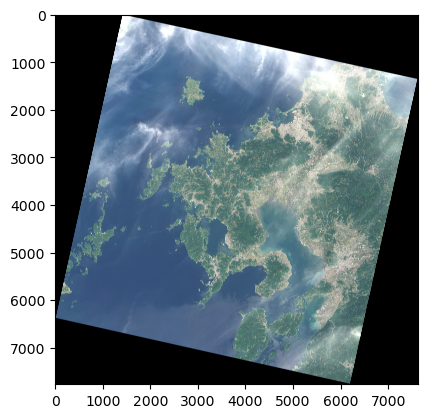

<Axes: >

In [29]:
src = rio.open("LC08_L1TP_113037_20230502_20230509_02_T1_TOA_STACKED.tif")
data = src.read(masked = True)
src.close()

%matplotlib inline
show(histogram_stretch(data[[3,2,1],:,:], 0, 99))

In [30]:
# Load our previously trained models
pipeline = load('pipeline.joblib') 
pca_pipeline = load('pca_pipeline.joblib')

In [31]:
# predict the Nagasaki data using the pipeline
# reshape the data from the entire dataset:
height = data.shape[1]
width = data.shape[2]

new_shape = (height * width, data.shape[0])
# swap axes and reshape
X_test = data.swapaxes(0,2).reshape(new_shape)

start_time = time.time()
# run the pipeline on the data the data - note that we do not use "fit" since our models are 
# already trained

# also note that at this point in time sklearn does not have the ability to predict on masked arrays; 
# specifically the model will ignore any masks on any arrays passed to the predict method
y_test = pipeline.predict(X_test)

# Reshape back into a 2D array
y_test = y_test.reshape(width, height).T

end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Convert elapsed_time to minutes and seconds
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

# Print the elapsed time in seconds
print(f"Elapsed time: {minutes} minutes and {seconds} seconds")

Elapsed time: 3 minutes and 7 seconds


In [32]:
# Use this to transform our nagasaki_reshaped (which has a bunch fo string labels) into integers

lulc_dict = dict((
    ("Urban", 0),
    ("Cropland", 1),
    ("Forest", 2),
    ("Water", 3),
    ("Bare Land", 4),
))

# Invert dictionary
inv_dict = {v: k for k, v in lulc_dict.items()}

# apparently faster - returns unique values as well as the indices that can be used to reconstruct
# the array
u, inv = np.unique(y_test, return_inverse = True)
y_labels = np.array([lulc_dict[x] for x in u])[inv].reshape(y_test.shape)

# Set up dictionary for color map
colors = dict((
    (0, "grey"),   # Urban 
    (1, "xkcd:lime green"),      # Cropland 
    (2, "green"),    # Forest 
    (3, "blue"),   # Water 
    (4, "xkcd:brown")
))

cmap = ListedColormap([colors[key] for key in colors], name = "LULC")

In [33]:
%matplotlib qt5

# We can use the results of our supervised machine learning model to refine our training polygons

# you can clearly see that cloud cover really screws up the classification. This makes sense because 
# cloud cover interferes with the spectral signature
fig, ax = plt.subplots(1,2, figsize = (20,10))
i = ax[1].imshow(y_labels, cmap = cmap, interpolation = "nearest")
ax[0].imshow(rio.plot.reshape_as_image(histogram_stretch(data[[3,2,1],:,:], 0, 99)))
ep.draw_legend(im_ax = i, titles = [inv_dict[key] for key in np.unique(y_labels)], cmap = cmap)
plt.tight_layout()

C:\Users\tranq\anaconda3\lib\site-packages\numpy\lib\function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


In [34]:
# predict the Nagasaki data using the pipeline
# reshape the data from the entire dataset:

start_time = time.time()
# run the pipeline on the data the data - note that we do not use "fit" since our models are 
# already trained

# also note that at this point in time sklearn does not have the ability to predict on masked arrays; 
# specifically the model will ignore any masks on any arrays passed to the predict method
y_test_pca = pca_pipeline.predict(X_test)

# Reshape back into a 2D array
y_test_pca = y_test_pca.reshape(width, height).T

end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Convert elapsed_time to minutes and seconds
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

# Print the elapsed time in seconds
print(f"Elapsed time: {minutes} minutes and {seconds} seconds")

# it's actually quite ridiculous: the non-PCA algorithm took two minutes and 41 seconds, but the PCA 
# algorithm took 38 seconds. This shows how dimensionality reduction can significantly reduce the 
# time taken for machine learning

Elapsed time: 0 minutes and 46 seconds


In [35]:
%matplotlib qt5

# We can use the results of our supervised machine learning model to refine our training polygons
u, inv = np.unique(y_test_pca, return_inverse = True)
y_labels_pca = np.array([lulc_dict[x] for x in u])[inv].reshape(y_test_pca.shape)

fig, ax = plt.subplots(1,2, figsize = (20,10))
i = ax[1].imshow(y_labels_pca, cmap = cmap, interpolation = "nearest")
ax[0].imshow(rio.plot.reshape_as_image(histogram_stretch(data[[3,2,1],:,:], 0, 99)))
ep.draw_legend(im_ax = i, titles = [inv_dict[key] for key in np.unique(y_labels_pca)], cmap = cmap)
plt.tight_layout()

C:\Users\tranq\anaconda3\lib\site-packages\numpy\lib\function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=5)), ('gaussiannb', GaussianNB())])